# Week: 1

## Setup and Imports

In [28]:
!pip3 install pygame --no-cache-dir

In [29]:
!pip3 install --upgrade setuptools
!pip3 install --upgrade pkg_resources

ERROR: Could not find a version that satisfies the requirement pkg_resources (from versions: none)
ERROR: No matching distribution found for pkg_resources


In [30]:
!pip3 install gymnasium box2d swig matplotlib torch torchvision numpy "gymnasium[other]"

In [31]:
import gymnasium as gym

## Working

In [32]:
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="ansi")

print("Initial Environment:")
state, info = env.reset()
print(f"Initial State: {state}")
print(f"Initial Info: {info}")
print("Environment:")
print(env.render())

print("Observation Space:", env.observation_space)

print("Action Space:", env.action_space)

print("\nExample of transition probabilities for state 0 and action 1 (Right):")
print(env.unwrapped.P)
print(len(env.unwrapped.P[0]))
print(len(env.unwrapped.P[0][1]))
print(env.unwrapped.P[0][1])


Initial Environment:
Initial State: 0
Initial Info: {'prob': 1}
Environment:

SFFF
FHFH
FFFH
HFFG

Observation Space: Discrete(16)
Action Space: Discrete(4)

Example of transition probabilities for state 0 and action 1 (Right):
{0: {0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 1: {0: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 2: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0,

### Cart Pole DQN

Device set to: mps
GPU in work
Will record videos at episodes: [np.int64(0), np.int64(111), np.int64(222), np.int64(333), np.int64(444), np.int64(555), np.int64(666), np.int64(777), np.int64(888), np.int64(999)]
Starting DQN Training on mps for 1000 episodes...
Will print progress every 50 episodes
Recording video for episode 0
Video saved for episode 0 with reward: 11.0
Episode   50 | Avg Reward:    19.8 | Avg Loss: 0.1898 | Epsilon: 0.774
Training started at episode 100
Episode  100 | Avg Reward:    18.6 | Avg Loss: 0.0014 | Epsilon: 0.603
Recording video for episode 111
Video saved for episode 111 with reward: 13.0
Episode  150 | Avg Reward:    15.0 | Avg Loss: 0.0029 | Epsilon: 0.469
Episode  200 | Avg Reward:    12.9 | Avg Loss: 0.0053 | Epsilon: 0.365
Recording video for episode 222
Video saved for episode 222 with reward: 9.0
Episode  250 | Avg Reward:    12.5 | Avg Loss: 0.0077 | Epsilon: 0.284
Episode  300 | Avg Reward:    12.5 | Avg Loss: 0.0103 | Epsilon: 0.221
Recording vid

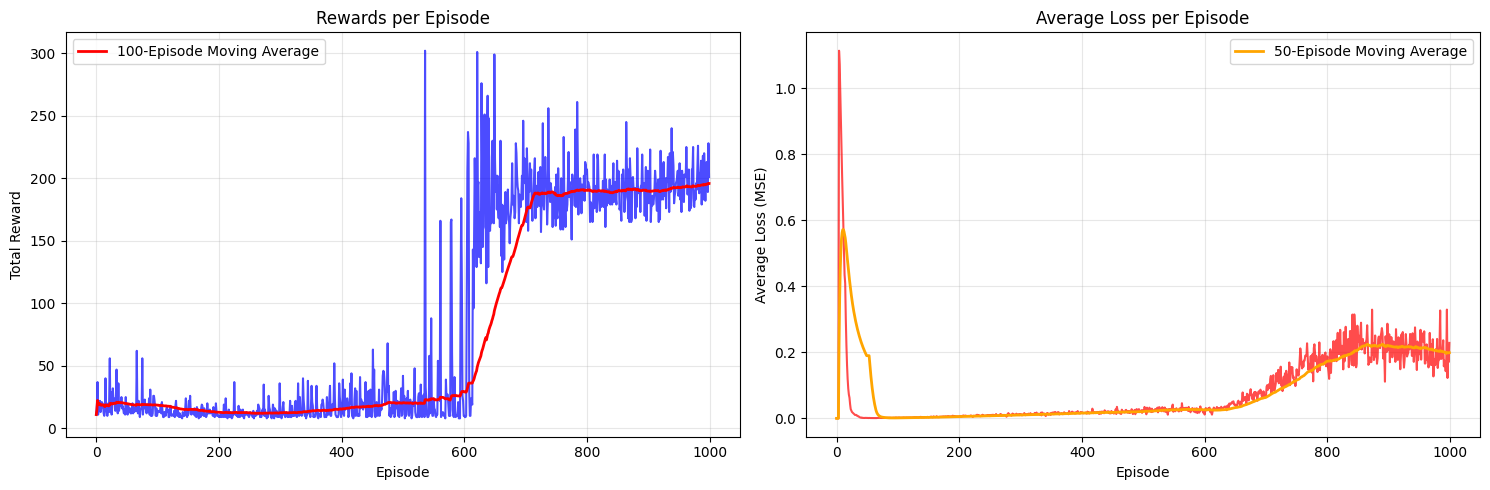


TRAINING COMPLETED!
Total Episodes: 1000
Best Score: 302.0
Final Average (100 eps): 195.8
Final Epsilon: 0.010
Total Training Steps: 21329
Videos saved in 'cartpole_videos' directory for 10 episodes
Model saved as 'dqn_cartpole_model.pth'


In [33]:
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import numpy as np
import random
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device set to: {device}")
if device.type == 'mps':
    print("GPU in work")
else:
    print("no GPU founded , CPU in work")

env = gym.make("CartPole-v1", render_mode="rgb_array")

REPLAY_MEMORY_SIZE = 100_000
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
EPISODES = 1_000
DISCOUNT = 0.99
MINI_BATCH_SIZE = 100
INTERPOLATION_PARAMETER = 1e-3  
TRAIN_FREQUENCY = 4  
SHOW_PREVIEW = False
AGGREGATE_STATS_EVERY = 50
LEARNING_RATE = 5e-4  
NUM_VIDEOS = 10

epsilon = 1.0
state_shape = env.observation_space.shape[0]
num_actions = env.action_space.n

class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(DQNNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self):
        self.model = DQNNetwork(state_shape, num_actions).to(device)
        self.target_model = DQNNetwork(state_shape, num_actions).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.t_step = 0
        self.losses = []

    def update_replay_memory(self, transition):
        return self.replay_memory.append(transition)
    
    def soft_update(self, local_model, target_model, interpolation_parameter):
        # Update target network weights slowly
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_parameter * local_param.data + 
                                   (1.0 - interpolation_parameter) * target_param.data)
    
    def train(self, done):
        # Train every few steps to improve stability
        self.t_step = (self.t_step + 1) % TRAIN_FREQUENCY
        if self.t_step != 0:
            return
            
        if len(self.replay_memory) < MINI_BATCH_SIZE:
            return
        
        minibatch = random.sample(self.replay_memory, MINI_BATCH_SIZE)

        # Convert to tensors
        current_states = torch.FloatTensor([transition[0] for transition in minibatch]).to(device)
        actions = torch.LongTensor([transition[1] for transition in minibatch]).to(device)
        rewards = torch.FloatTensor([transition[2] for transition in minibatch]).to(device)
        new_states = torch.FloatTensor([transition[3] for transition in minibatch]).to(device)
        dones = torch.BoolTensor([transition[4] for transition in minibatch]).to(device)

        # Get current Q values
        current_q_values = self.model(current_states).gather(1, actions.unsqueeze(1))

        # Get next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_model(new_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards.unsqueeze(1) + (DISCOUNT * next_q_values * (~dones).unsqueeze(1))

        # Calculate loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Store loss for tracking
        self.losses.append(loss.item())
        
        # Update model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.model, self.target_model, INTERPOLATION_PARAMETER)

    def get_qs(self, state):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.model(state_tensor).cpu().numpy()[0]

    def act(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon: 
            action = env.action_space.sample()
        else:
            action = np.argmax(self.get_qs(state))
        return action

agent = DQNAgent()
episode_rewards = []
scores_window = deque(maxlen=100)
avg_losses = []

# Select episodes for video recording
video_episodes = np.linspace(0, EPISODES-1, NUM_VIDEOS, dtype=int)
print(f"Will record videos at episodes: {list(video_episodes)}")

print(f"Starting DQN Training on {device} for {EPISODES} episodes...")
print(f"Will print progress every {AGGREGATE_STATS_EVERY} episodes")

for episode in range(EPISODES):
    # Check if we should record this episode
    record_video = episode in video_episodes
    
    if record_video:
        # Setup video recording
        video_env = gym.make("CartPole-v1", render_mode="rgb_array")
        video_env = gym.wrappers.RecordVideo(
            video_env, 
            f"cartpole_videos/episode_{episode}",
            episode_trigger=lambda x: True,
            name_prefix=f"dqn_episode_{episode}"
        )
        current_state, _ = video_env.reset()
        print(f"Recording video for episode {episode}")
    else:
        current_state, _ = env.reset()
    
    total_reward = 0
    done = False
    episode_losses = []

    if episode == MINI_BATCH_SIZE:
        print(f"Training started at episode {episode}")

    while not done:
        action = agent.act(current_state, epsilon)
        
        if record_video:
            new_state, reward, terminated, truncated, _ = video_env.step(action)
        else:
            new_state, reward, terminated, truncated, _ = env.step(action)
            
        done = terminated or truncated
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        
        # Track losses for this episode
        loss_before = len(agent.losses)
        agent.train(done)   
        
        if len(agent.losses) > loss_before:
            episode_losses.append(agent.losses[-1])

        current_state = new_state
        total_reward += reward

    # Close video environment
    if record_video:
        video_env.close()
        print(f"Video saved for episode {episode} with reward: {total_reward:.1f}")

    episode_rewards.append(total_reward)
    scores_window.append(total_reward)
    
    # Decay exploration rate
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    
    # Calculate average loss for this episode
    if episode_losses:
        avg_episode_loss = np.mean(episode_losses)
        avg_losses.append(avg_episode_loss)
    else:
        avg_losses.append(0)

    # Print progress
    if episode % AGGREGATE_STATS_EVERY == 0 and episode > 0:
        avg_reward = np.mean(scores_window)
        avg_loss = np.mean(avg_losses[-AGGREGATE_STATS_EVERY:]) if avg_losses else 0
        print(f'Episode {episode:4d} | Avg Reward: {avg_reward:7.1f} | Avg Loss: {avg_loss:.4f} | Epsilon: {epsilon:.3f}')
        
        # Check if solved
        if len(scores_window) >= 100 and avg_reward >= 195.0:
            print(f'Environment SOLVED in {episode} episodes!')
            print(f'Average Score: {avg_reward:.2f}')
            break

env.close()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot rewards
ax1.plot(episode_rewards, color='blue', alpha=0.7)
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.set_title("Rewards per Episode")
ax1.grid(True, alpha=0.3)

# Plot moving average of rewards
window_size = 100
if len(episode_rewards) >= window_size:
    moving_avg = []
    for i in range(len(episode_rewards)):
        if i < window_size:
            moving_avg.append(np.mean(episode_rewards[:i+1]))
        else:
            moving_avg.append(np.mean(episode_rewards[i-window_size+1:i+1]))
    ax1.plot(moving_avg, color='red', linewidth=2, label=f'{window_size}-Episode Moving Average')
    ax1.legend()

# Plot loss
if avg_losses:
    ax2.plot(avg_losses, color='red', alpha=0.7)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Average Loss (MSE)")
    ax2.set_title("Average Loss per Episode")
    ax2.grid(True, alpha=0.3)
    
    # Plot moving average of loss
    loss_window = 50
    if len(avg_losses) >= loss_window:
        loss_moving_avg = []
        for i in range(len(avg_losses)):
            if i < loss_window:
                loss_moving_avg.append(np.mean(avg_losses[:i+1]))
            else:
                loss_moving_avg.append(np.mean(avg_losses[i-loss_window+1:i+1]))
        ax2.plot(loss_moving_avg, color='orange', linewidth=2, label=f'{loss_window}-Episode Moving Average')
        ax2.legend()

plt.tight_layout()
plt.show()

# Print final results
env.close()
print(f"\nTRAINING COMPLETED!")
print(f"Total Episodes: {len(episode_rewards)}")
print(f"Best Score: {max(episode_rewards):.1f}")
print(f"Final Average (100 eps): {np.mean(episode_rewards[-100:]):.1f}")
print(f"Final Epsilon: {epsilon:.3f}")
print(f"Total Training Steps: {len(agent.losses)}")
print(f"Videos saved in 'cartpole_videos' directory for {NUM_VIDEOS} episodes")

# Save the model
torch.save(agent.model.state_dict(), 'dqn_cartpole_model.pth')
print(f"Model saved as 'dqn_cartpole_model.pth'")

### Lunar Lander DQN

In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import numpy as np
import random
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device set to: {device}")
if device.type == 'mps':
    print("GPU in work")
else:
    print("no GPU founded , CPU in work")

env = gym.make("LunarLander-v3", render_mode="rgb_array")

REPLAY_MEMORY_SIZE = 100_000
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
EPISODES = 1_000
DISCOUNT = 0.99
MINI_BATCH_SIZE = 100
INTERPOLATION_PARAMETER = 1e-3  
TRAIN_FREQUENCY = 4  
SHOW_PREVIEW = False
AGGREGATE_STATS_EVERY = 50
LEARNING_RATE = 5e-4  
NUM_VIDEOS = 10

epsilon = 1.0
state_shape = env.observation_space.shape[0]
num_actions = env.action_space.n

class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(DQNNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self):
        self.model = DQNNetwork(state_shape, num_actions).to(device)
        self.target_model = DQNNetwork(state_shape, num_actions).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.t_step = 0
        self.losses = []

    def update_replay_memory(self, transition):
        return self.replay_memory.append(transition)
    
    def soft_update(self, local_model, target_model, interpolation_parameter):
        # Update target network weights slowly
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_parameter * local_param.data + 
                                   (1.0 - interpolation_parameter) * target_param.data)
    
    def train(self, done):
        # Train every few steps to improve stability
        self.t_step = (self.t_step + 1) % TRAIN_FREQUENCY
        if self.t_step != 0:
            return
            
        if len(self.replay_memory) < MINI_BATCH_SIZE:
            return
        
        minibatch = random.sample(self.replay_memory, MINI_BATCH_SIZE)

        # Convert to tensors
        current_states = torch.FloatTensor([transition[0] for transition in minibatch]).to(device)
        actions = torch.LongTensor([transition[1] for transition in minibatch]).to(device)
        rewards = torch.FloatTensor([transition[2] for transition in minibatch]).to(device)
        new_states = torch.FloatTensor([transition[3] for transition in minibatch]).to(device)
        dones = torch.BoolTensor([transition[4] for transition in minibatch]).to(device)

        # Get current Q values
        current_q_values = self.model(current_states).gather(1, actions.unsqueeze(1))

        # Get next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_model(new_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards.unsqueeze(1) + (DISCOUNT * next_q_values * (~dones).unsqueeze(1))

        # Calculate loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Store loss for tracking
        self.losses.append(loss.item())
        
        # Update model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.model, self.target_model, INTERPOLATION_PARAMETER)

    def get_qs(self, state):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.model(state_tensor).cpu().numpy()[0]

    def act(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon: 
            action = env.action_space.sample()
        else:
            action = np.argmax(self.get_qs(state))
        return action

agent = DQNAgent()
episode_rewards = []
scores_window = deque(maxlen=100)
avg_losses = []

# Select episodes for video recording
video_episodes = np.linspace(0, EPISODES-1, NUM_VIDEOS, dtype=int)
print(f"Will record videos at episodes: {list(video_episodes)}")

print(f"Starting DQN Training on {device} for {EPISODES} episodes...")
print(f"Will print progress every {AGGREGATE_STATS_EVERY} episodes")

for episode in range(EPISODES):
    # Check if we should record this episode
    record_video = episode in video_episodes
    
    if record_video:
        # Setup video recording
        video_env = gym.make("CartPole-v1", render_mode="rgb_array")
        video_env = gym.wrappers.RecordVideo(
            video_env, 
            f"lunar_lander_videos/episode_{episode}",
            episode_trigger=lambda x: True,
            name_prefix=f"dqn_episode_{episode}"
        )
        current_state, _ = video_env.reset()
        print(f"Recording video for episode {episode}")
    else:
        current_state, _ = env.reset()
    
    total_reward = 0
    done = False
    episode_losses = []

    if episode == MINI_BATCH_SIZE:
        print(f"Training started at episode {episode}")

    while not done:
        action = agent.act(current_state, epsilon)
        
        if record_video:
            new_state, reward, terminated, truncated, _ = video_env.step(action)
        else:
            new_state, reward, terminated, truncated, _ = env.step(action)
            
        done = terminated or truncated
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        
        # Track losses for this episode
        loss_before = len(agent.losses)
        agent.train(done)   
        
        if len(agent.losses) > loss_before:
            episode_losses.append(agent.losses[-1])

        current_state = new_state
        total_reward += reward

    # Close video environment
    if record_video:
        video_env.close()
        print(f"Video saved for episode {episode} with reward: {total_reward:.1f}")

    episode_rewards.append(total_reward)
    scores_window.append(total_reward)
    
    # Decay exploration rate
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    
    # Calculate average loss for this episode
    if episode_losses:
        avg_episode_loss = np.mean(episode_losses)
        avg_losses.append(avg_episode_loss)
    else:
        avg_losses.append(0)

    # Print progress
    if episode % AGGREGATE_STATS_EVERY == 0 and episode > 0:
        avg_reward = np.mean(scores_window)
        avg_loss = np.mean(avg_losses[-AGGREGATE_STATS_EVERY:]) if avg_losses else 0
        print(f'Episode {episode:4d} | Avg Reward: {avg_reward:7.1f} | Avg Loss: {avg_loss:.4f} | Epsilon: {epsilon:.3f}')
        
        # Check if solved
        if len(scores_window) >= 100 and avg_reward >= 250.0:
            print(f'Environment SOLVED in {episode} episodes!')
            print(f'Average Score: {avg_reward:.2f}')
            break

env.close()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot rewards
ax1.plot(episode_rewards, color='blue', alpha=0.7)
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.set_title("Rewards per Episode")
ax1.grid(True, alpha=0.3)

# Plot moving average of rewards
window_size = 100
if len(episode_rewards) >= window_size:
    moving_avg = []
    for i in range(len(episode_rewards)):
        if i < window_size:
            moving_avg.append(np.mean(episode_rewards[:i+1]))
        else:
            moving_avg.append(np.mean(episode_rewards[i-window_size+1:i+1]))
    ax1.plot(moving_avg, color='red', linewidth=2, label=f'{window_size}-Episode Moving Average')
    ax1.legend()

# Plot loss
if avg_losses:
    ax2.plot(avg_losses, color='red', alpha=0.7)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Average Loss (MSE)")
    ax2.set_title("Average Loss per Episode")
    ax2.grid(True, alpha=0.3)
    
    # Plot moving average of loss
    loss_window = 50
    if len(avg_losses) >= loss_window:
        loss_moving_avg = []
        for i in range(len(avg_losses)):
            if i < loss_window:
                loss_moving_avg.append(np.mean(avg_losses[:i+1]))
            else:
                loss_moving_avg.append(np.mean(avg_losses[i-loss_window+1:i+1]))
        ax2.plot(loss_moving_avg, color='orange', linewidth=2, label=f'{loss_window}-Episode Moving Average')
        ax2.legend()

plt.tight_layout()
plt.show()

# Print final results
env.close()
print(f"\nTRAINING COMPLETED!")
print(f"Total Episodes: {len(episode_rewards)}")
print(f"Best Score: {max(episode_rewards):.1f}")
print(f"Final Average (100 eps): {np.mean(episode_rewards[-100:]):.1f}")
print(f"Final Epsilon: {epsilon:.3f}")
print(f"Total Training Steps: {len(agent.losses)}")
print(f"Videos saved in 'lunar_lander_videos' directory for {NUM_VIDEOS} episodes")

# Save the model
torch.save(agent.model.state_dict(), 'dqn_lunarlander_model.pth')
print(f"Model saved as 'dqn_lunarlander_model.pth'")